In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc

In [2]:
# Obtaining data
e_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_e-_3000x400.fiTQun.root')['fiTQun']
mu_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_mu-_3000x400.fiTQun.root')['fiTQun']
pi0_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_pi0_3000x400.fiTQun.root')['fiTQun']

In [3]:
# Structure within a fitqun output file
print(e_data.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
cluster_ncand        | int32_t                  | AsDtype('>i4')
cluster_tstart       | float[]                  | AsJagged(AsDtype('>f4'))
cluster_tend         | float[]                  | AsJagged(AsDtype('>f4'))
cluster_nhits        | int32_t[]                | AsJagged(AsDtype('>i4'))
cluster_totq         | float[]                  | AsJagged(AsDtype('>f4'))
cluster_goodflag     | int32_t[]                | AsJagged(AsDtype('>i4'))
cluster_npeaks       | int32_t[][6]             | AsJagged(AsDtype("('>i4', (...
cluster_ipeak        | int32_t[][6][10]         | AsJagged(AsDtype("('>i4', (...
cluster_timeofpeak   | float[][6][10]           | AsJagged(AsDtype("('>f4', (...
muechk_ncand         | int32_t[6]               | AsDtype("('>i4', (6,))")
muechk_toya          | float[6]                 | AsDtype("('>f4', (6,))")
muech

In [9]:
print(pi0_data['fqpi0nll'].array())

[[1.71e+04, 0], [2.15e+04, 0], [1.16e+04, 0, ... 0], [2.6e+04, 0], [2.11e+04, 0]]


# Extracting 1 ring NLL data

In [3]:
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nll_1 = np.array(e_data['fq1rnll'].array()[:,0,1])
e_nll_2 = np.array(e_data['fq1rnll'].array()[:,0,2])
mu_nll_1 = np.array(mu_data['fq1rnll'].array()[:,0,1])
mu_nll_2 = np.array(mu_data['fq1rnll'].array()[:,0,2])

### Histogram checking

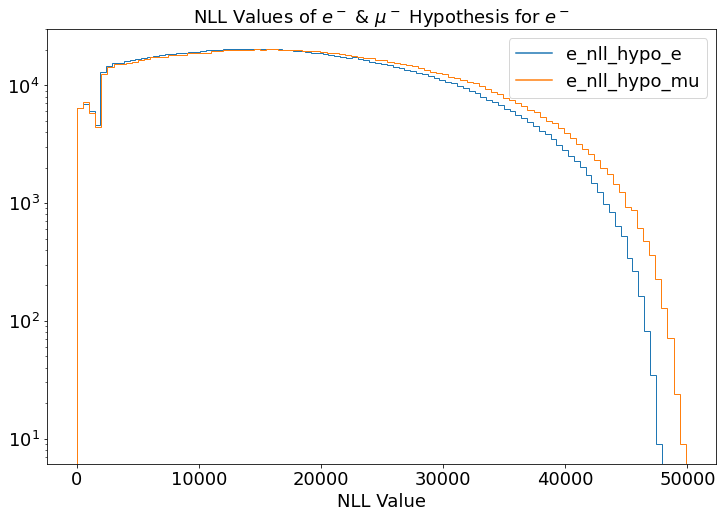

In [19]:
# Plotting histogram to check data
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_1, bins=100, label='e_nll_hypo_e', histtype='step', log=True)
ax.hist(e_nll_2, bins=100, label='e_nll_hypo_mu', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('NLL Values of $e^-$ & $\mu^-$ Hypothesis for $e^-$', fontsize=18)
plt.show()

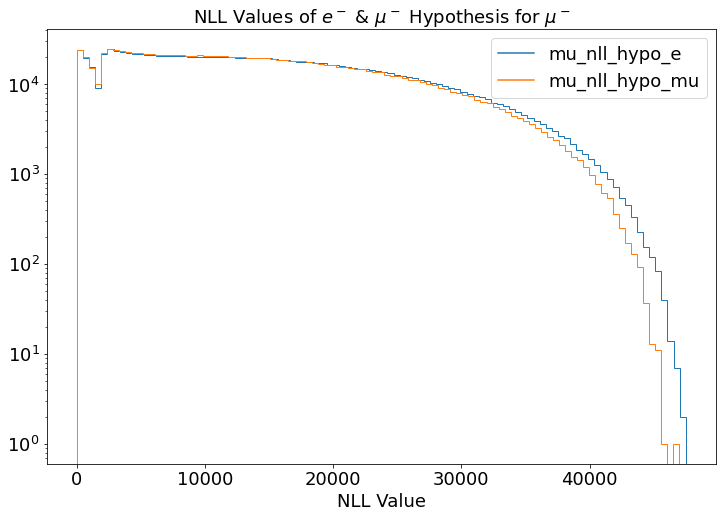

In [20]:
# Plotting mu histogram to check data
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(mu_nll_1, bins=100, label='mu_nll_hypo_e', histtype='step', log=True)
ax.hist(mu_nll_2, bins=100, label='mu_nll_hypo_mu', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('NLL Values of $e^-$ & $\mu^-$ Hypothesis for $\mu^-$', fontsize=18)
plt.show()

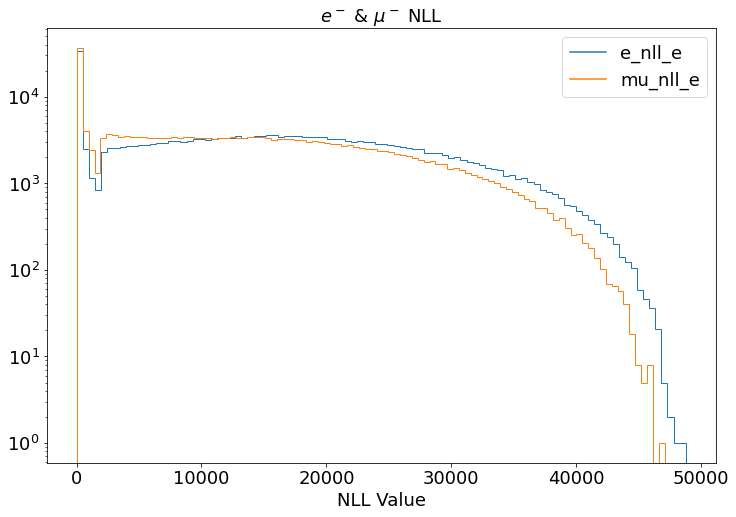

In [45]:
# Plotting e and mu histograms together
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_1, bins=100, label='e_nll_e', histtype='step', log=True)
ax.hist(mu_nll_1, bins=100, label='mu_nll_e', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('$e^-$ & $\mu^-$ NLL', fontsize=18)
plt.show()

# Processing NLL for e and mu

In [4]:
e_nll_diff_e = e_nll_1 - e_nll_2  # Small number = e; big number = mu
e_nll_diff_mu = e_nll_2 - e_nll_1  # Small number = mu; big number = e

mu_nll_diff_e = mu_nll_1 - mu_nll_2  # Small number = e, big number = mu
mu_nll_diff_mu = mu_nll_2 - mu_nll_1  # Small number = mu, big number = e

### Histogram checking

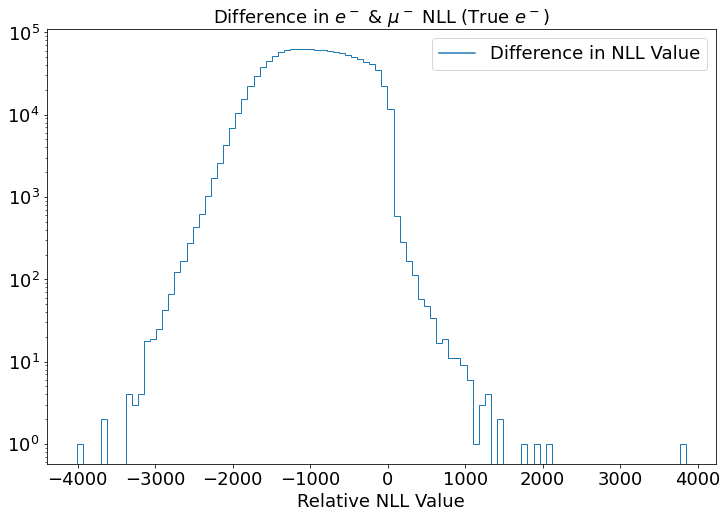

In [22]:
# Plotting the difference in e and mu NLL value
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_diff_e, bins=100, label='Difference in NLL Value', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('Relative NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $e^-$ & $\mu^-$ NLL (True $e^-$)', fontsize=18)
plt.show()

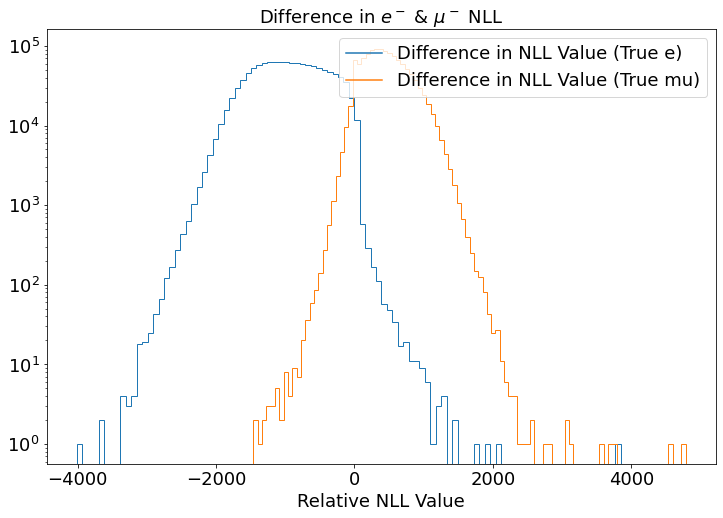

In [29]:
# Plotting the difference in e and mu NLL value
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_diff_e, bins=100, label='Difference in NLL Value (True e)', histtype='step', log=True)
ax.hist(mu_nll_diff_e, bins=100, label='Difference in NLL Value (True mu)', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('Relative NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $e^-$ & $\mu^-$ NLL', fontsize=18)
plt.show()

# Pi0 NLL and reconstructed Pi0 mass

In [5]:
e_pi0nll = np.array(e_data['fqpi0nll'].array()[:,0])
pi0_pi0nll = np.array(pi0_data['fqpi0nll'].array()[:, 0])
pi0_1rnll_e  = np.array(pi0_data['fq1rnll'].array()[:,0,1])

In [6]:
e_as_e_from_pi0nll = e_nll_1 - e_pi0nll          # small number = e-; big number = pi0
pi0_as_e_from_pi0nll = pi0_1rnll_e - pi0_pi0nll  # small number = e-; big number = pi0

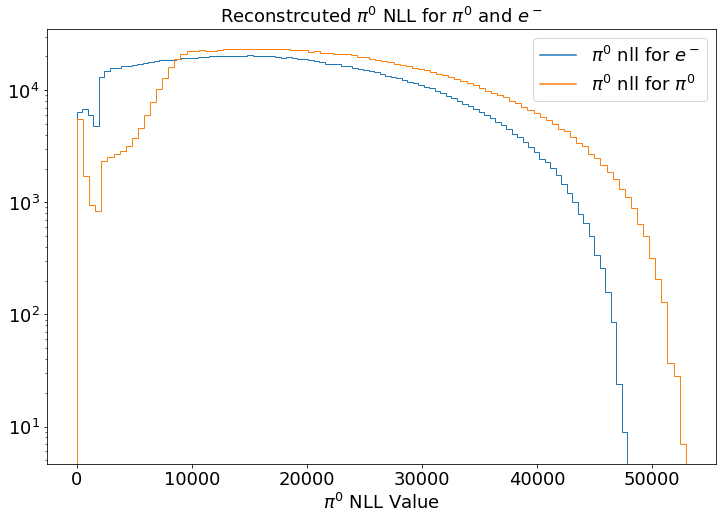

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_pi0nll, bins=100, label='$\pi^0$ nll for $e^-$', histtype='step', log=True)
ax.hist(pi0_pi0nll, bins=100, label='$\pi^0$ nll for $\pi^0$', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('$\pi^0$ NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Reconstrcuted $\pi^0$ NLL for $\pi^0$ and $e^-$', fontsize=18)
plt.show()

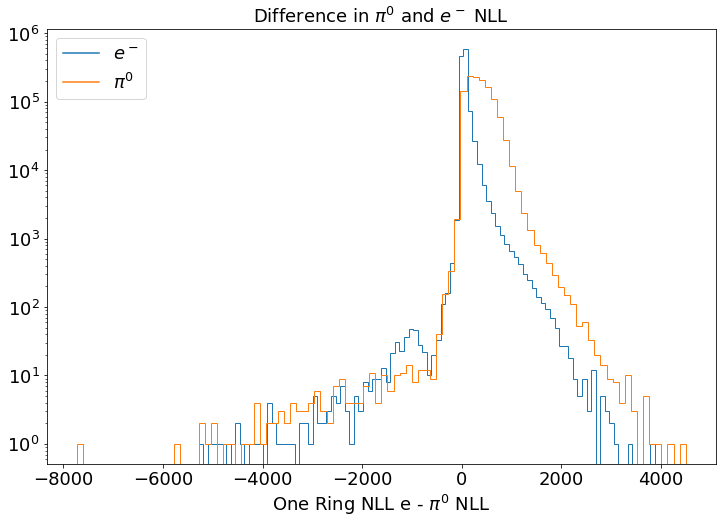

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_as_e_from_pi0nll, bins=100, label='$e^-$', histtype='step', log=True)
ax.hist(pi0_as_e_from_pi0nll, bins=100, label='$\pi^0$', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('One Ring NLL e - $\pi^0$ NLL', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $\pi^0$ and $e^-$ NLL', fontsize=18)
plt.show()

# Generating labels from FiTQun output

In [9]:
# For e-, mu- separation
# Truth label
e_labels_e = np.ones(e_nll_diff_e.shape)
e_labels_mu = np.ones(e_nll_diff_mu.shape)
mu_labels_e = np.ones(mu_nll_diff_e.shape)*2
mu_labels_mu = np.ones(mu_nll_diff_mu.shape)*2


# concatenate labels and differences from mu and e events
diff_e = np.concatenate((mu_nll_diff_e, e_nll_diff_e), axis=0).astype(int)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0).astype(int)
diff_mu = np.concatenate((mu_nll_diff_mu, e_nll_diff_mu), axis=0).astype(int)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0).astype(int)

In [10]:
# For e-, pi0 separation
# Truth label for pi0
pi0_labeled_e = np.ones(pi0_pi0nll.shape)*3

# concatenate labels
diff_e_pi0 = np.concatenate((pi0_as_e_from_pi0nll, e_as_e_from_pi0nll), axis=0).astype(int)
labels_e_pi0 = np.concatenate((pi0_labeled_e, e_labels_e), axis=0).astype(int)

# Calculating FPR and TPR

In [11]:
# for e/mu separation
fq_fpr_e, fq_tpr_e, fq_threshold_e = roc_curve(labels_e, diff_e, pos_label=2)  # Note this asks for POSIIVE 
                                                                               # label. In the above NLL plot, pos
                                                                               # for true e situation is mu 
                                                                               # (which is 2)
fq_fpr_mu, fq_tpr_mu, fq_threshold_mu = roc_curve(labels_mu, diff_mu, pos_label=1)  # Similar as above

In [12]:
# for e/pi0 separation
fq_fpr_e_for_pi0, fq_tpr_e_for_pi0, fq_threshold_e_for_pi0 = roc_curve(labels_e_pi0, diff_e_pi0, pos_label=3)

In [13]:
# Calculate AUC as a check
true_e_auc = auc(fq_fpr_e, fq_tpr_e)
true_mu_auc = auc(fq_fpr_mu, fq_tpr_mu)
true_e_pi0_auc = auc(fq_fpr_e_for_pi0, fq_tpr_e_for_pi0)

In [15]:
print(true_e_auc, true_mu_auc, true_e_pi0_auc)

0.997985281328125 0.997985281328125 0.9218631927385417


# FiTQun reconstructed momentum

In [16]:
e_mom  = np.array(e_data.arrays('fq1rmom')['fq1rmom'][:, 0, 1])
mu_mom = np.array(mu_data.arrays('fq1rmom')['fq1rmom'][:, 0, 2])
fq_mom = np.concatenate((e_mom, mu_mom))
print(fq_mom)

[788.0307    25.759787 973.45557  ... 774.4779   442.98688  372.1551  ]


# FiTQun reconstructed momentum derived total energy

In [17]:
E_e       = np.sqrt(e_mom**2 + 0.510**2)  # m_e in MeV
E_mu      = np.sqrt(mu_mom**2 + 105**2)
fq_energies = np.concatenate((E_e, E_mu))

# Storing FiTQun NLL Scores and labels for plotting performance distribution

In [18]:
fq_likelihoods = np.concatenate((np.array(e_nll_diff_e), np.array(mu_nll_diff_e)))

fq_scores = np.zeros((fq_likelihoods.shape[0], 3))
print(fq_likelihoods.shape, fq_scores.shape)
fq_scores[:, 1] = fq_likelihoods
print(fq_scores)

fq_labels = np.concatenate((e_labels_e, mu_labels_e))
print(fq_labels, len(fq_labels))

(2400000,) (2400000, 3)
[[    0.         -1088.20800781     0.        ]
 [    0.          -162.39648438     0.        ]
 [    0.         -2159.52539062     0.        ]
 ...
 [    0.           589.32617188     0.        ]
 [    0.           269.97851562     0.        ]
 [    0.           283.71826172     0.        ]]
[1. 1. 1. ... 2. 2. 2.] 2400000


# Saving to npz file

In [19]:
np.savez('processed_fq_output_ROC.npz', 
         fq_fpr_e = fq_fpr_e, fq_tpr_e = fq_tpr_e, fq_threshold_e = fq_threshold_e, 
         fq_fpr_e_for_pi0 = fq_fpr_e_for_pi0, fq_tpr_e_for_pi0 = fq_tpr_e_for_pi0, 
         fq_threshold_e_for_pi0 = fq_threshold_e_for_pi0,
         fq_mom = fq_mom, fq_energies = fq_energies, fq_scores=fq_scores, fq_labels=fq_labels)